In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
np.random.seed(42)  # to make this code example reproducible
m = 100  # number of instances
X = 2 * np.random.rand(m, 1)  # column vector
y = 4 + 3 * X + np.random.randn(m, 1)  # column vector

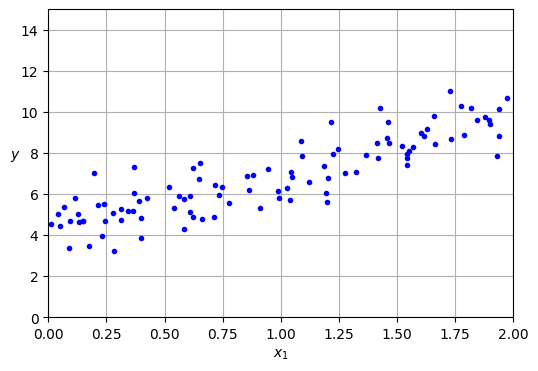

In [3]:
plt.figure(figsize=(6, 4))
plt.plot(X, y, "b.")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid()
plt.show()

In [4]:
from sklearn.preprocessing import add_dummy_feature

X_b = add_dummy_feature(X)  # add x0 = 1 to each instance
theta_best = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y


theta_best

array([[4.21509616],
       [2.77011339]])

In [5]:
X_new = np.array([[0], [2]])
X_new_b = add_dummy_feature(X_new)  # add x0 = 1 to each instance
y_predict = X_new_b @ theta_best
y_predict

array([[4.21509616],
       [9.75532293]])

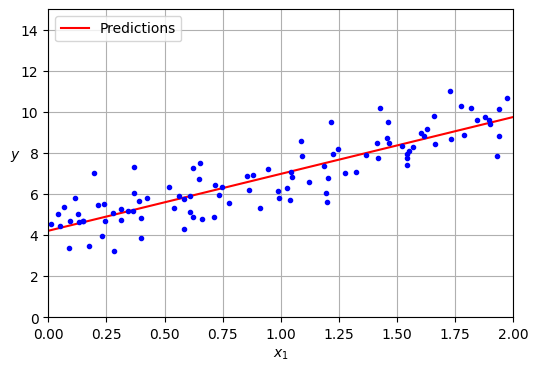

In [6]:
plt.figure(figsize=(6, 4)) 
plt.plot(X_new, y_predict, "r-", label="Predictions")
plt.plot(X, y, "b.")

plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid()
plt.legend(loc="upper left")

plt.show()

In [7]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

In [8]:
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

In [9]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.21509616],
       [2.77011339]])

In [10]:
np.linalg.pinv(X_b) @ y

array([[4.21509616],
       [2.77011339]])

## Gradient Descent

# Batch Gradient Descent

In [11]:
eta = 0.1  # learning rate
n_epochs = 1000
m = len(X_b)  # number of instances

np.random.seed(42)
theta = np.random.randn(2, 1)  # randomly initialized model parameters

for epoch in range(n_epochs):
    gradients = 2 / m * X_b.T @ (X_b @ theta - y)
    theta = theta - eta * gradients

In [12]:
theta

array([[4.21509616],
       [2.77011339]])

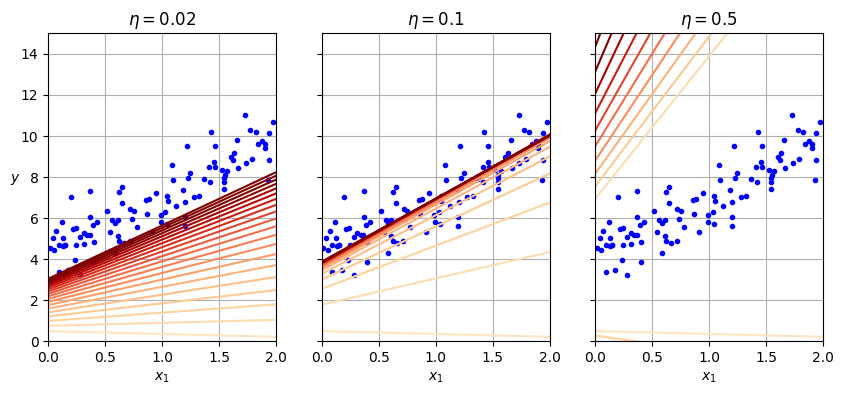

In [13]:
import matplotlib as mpl

def plot_gradient_descent(theta, eta):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_epochs = 1000
    n_shown = 20
    theta_path = []
    for epoch in range(n_epochs):
        if epoch < n_shown:
            y_predict = X_new_b @ theta
            color = mpl.colors.rgb2hex(plt.cm.OrRd(epoch / n_shown + 0.15))
            plt.plot(X_new, y_predict, linestyle="solid", color=color)
        gradients = 2 / m * X_b.T @ (X_b @ theta - y)
        theta = theta - eta * gradients
        theta_path.append(theta)
    plt.xlabel("$x_1$")
    plt.axis([0, 2, 0, 15])
    plt.grid()
    plt.title(fr"$\eta = {eta}$")
    return theta_path

np.random.seed(42)
theta = np.random.randn(2, 1)  # random initialization

plt.figure(figsize=(10, 4))
plt.subplot(131)
plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0)
plt.subplot(132)
theta_path_bgd = plot_gradient_descent(theta, eta=0.1)
plt.gca().axes.yaxis.set_ticklabels([])
plt.subplot(133)
plt.gca().axes.yaxis.set_ticklabels([])
plot_gradient_descent(theta, eta=0.5)
plt.show()

# Stochastic Gradient Descent

In [14]:
theta_path_sgd = []

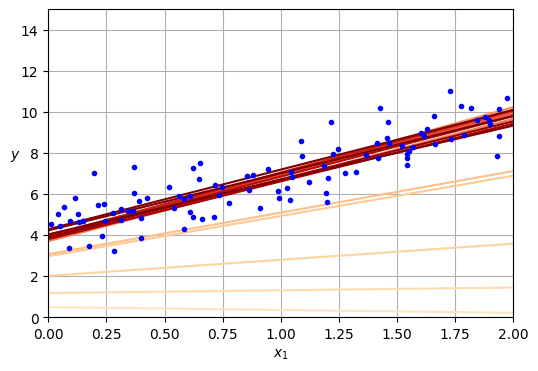

In [15]:
n_epochs = 50
t0, t1 = 5, 50  # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

np.random.seed(42)
theta = np.random.randn(2, 1)  # random initialization

n_shown = 20  
plt.figure(figsize=(6, 4))  

for epoch in range(n_epochs):
    for iteration in range(m):

        if epoch == 0 and iteration < n_shown:
            y_predict = X_new_b @ theta
            color = mpl.colors.rgb2hex(plt.cm.OrRd(iteration / n_shown + 0.15))
            plt.plot(X_new, y_predict, color=color)

        random_index = np.random.randint(m)
        xi = X_b[random_index : random_index + 1]
        yi = y[random_index : random_index + 1]
        gradients = 2 * xi.T @ (xi @ theta - yi)  # for SGD, do not divide by m
        eta = learning_schedule(epoch * m + iteration)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)  

plt.plot(X, y, "b.")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid()
plt.show()

In [16]:
theta

array([[4.21076011],
       [2.74856079]])

In [17]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-5, penalty=None, eta0=0.01,
                       n_iter_no_change=100, random_state=42)
sgd_reg.fit(X, y.ravel())  # y.ravel() because fit() expects 1D targets


,loss,'squared_error'
,penalty,None
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000
,tol,1e-05
,shuffle,True
,verbose,0
,epsilon,0.1
,random_state,42


In [18]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.21278812]), array([2.77270267]))

## Mini Batch Gradient Descent

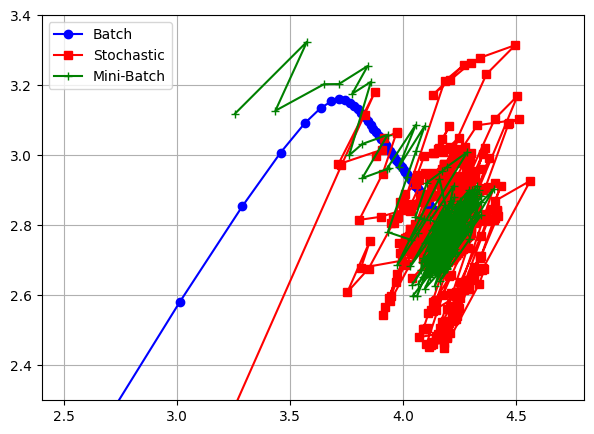

In [19]:
from math import ceil

n_epochs = 50
minibatch_size = 20
n_batches_per_epoch = ceil(m / minibatch_size)

np.random.seed(42)
theta = np.random.randn(2, 1)

t0, t1 = 200, 1000


def learning_schedule(t):
    return t0 / (t + t1)


theta_path_mgd = []
for epoch in range(n_epochs):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for iteration in range(0, n_batches_per_epoch):
        idx = iteration * minibatch_size
        xi = X_b_shuffled[idx : idx + minibatch_size]
        yi = y_shuffled[idx : idx + minibatch_size]
        gradients = 2 / minibatch_size * xi.T @ (xi @ theta - yi)
        eta = learning_schedule(epoch * n_batches_per_epoch + iteration)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)


plt.figure(figsize=(7,5))
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", label="Batch")
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", label="Mini-Batch")
plt.legend()
plt.grid()
plt.axis([2.4, 4.8, 2.3, 3.4])
plt.show()

## Polynomial Regression

In [20]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

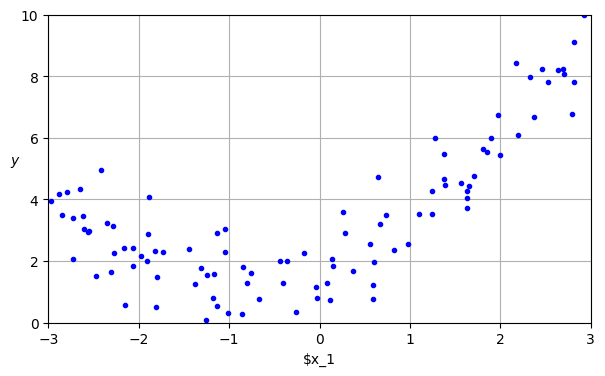

In [21]:
#  Plotting Data
plt.figure(figsize=(7, 4))
plt.plot(X, y, "b.")
plt.xlabel('$x_1')
plt.ylabel("$y$", rotation=0)
plt.axis([-3, 3, 0, 10])
plt.grid()
plt.show()

In [22]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

array([-0.75275929])

In [23]:
X_poly[0]

array([-0.75275929,  0.56664654])

In [24]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [25]:
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

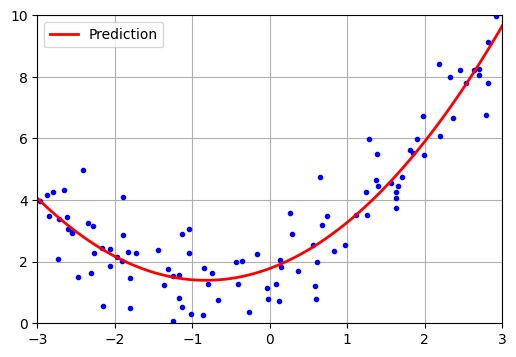

In [26]:
X_new = np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)

plt.figure(figsize=(6, 4))
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Prediction")
plt.axis([-3,3,0,10])
plt.legend()
plt.grid()
plt.show()

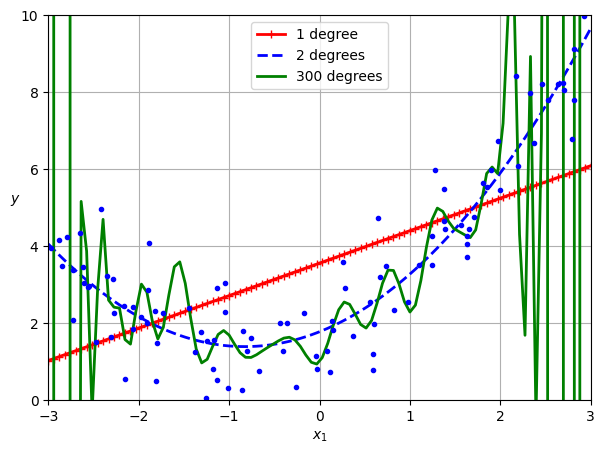

In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

plt.figure(figsize=(7, 5))

for style, width, degree in (("r-+", 2, 1), ("b--", 2, 2), ("g-", 2, 300)):
    preprocessing_pipeline = Pipeline(
        [
            ("polybig_features", PolynomialFeatures(degree=degree, include_bias=False)),
            ("std_scaler", StandardScaler()),
            ("lin_reg", LinearRegression()),
        ]
    )
    preprocessing_pipeline.fit(X, y)
    y_newbig = preprocessing_pipeline.predict(X_new)
    label = f"{degree} degree{'s' if degree > 1 else ''}"
    plt.plot(X_new, y_newbig, style, label=label, linewidth=width)

plt.plot(X, y, 'b.', linewidth=3)
plt.xlabel('$x_1$')
plt.ylabel('$y$', rotation=0)
plt.axis([-3,3,0,10])
plt.legend()
plt.grid()
plt.show()

## Learning Curve

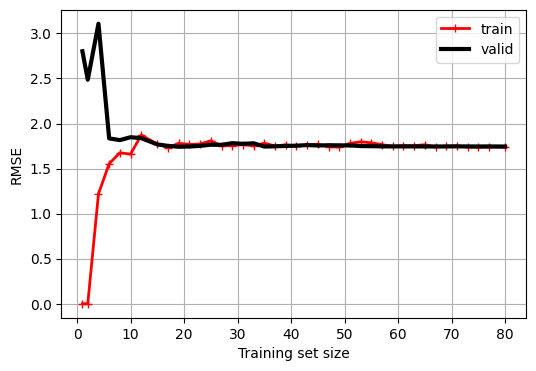

In [28]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(
    LinearRegression(),
    X,
    y,
    train_sizes=np.linspace(0.01, 1.0, 40),
    cv=5,
    scoring="neg_root_mean_squared_error",
)
train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.figure(figsize=(6, 4))
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "k-", linewidth=3, label="valid")

plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.grid()
plt.legend(loc='upper right')
# plt.axis([0, 80, 0, 2.5])
plt.show()


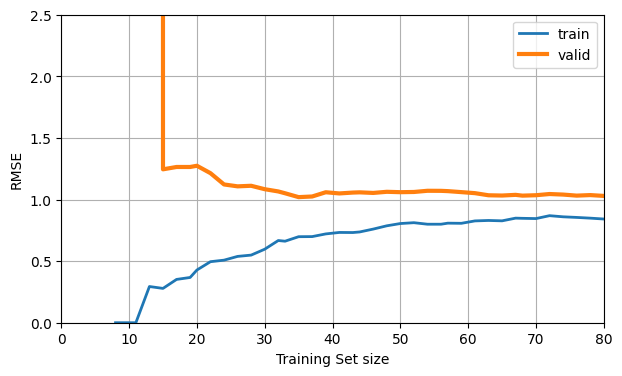

In [29]:
polynomial_regression = Pipeline(
    [
        ("polynomial", PolynomialFeatures(degree=10, include_bias=False)),
        ("linear_regression", LinearRegression()),
    ]
)

train_sizes, train_scores, valid_scores = learning_curve(
    polynomial_regression,
    X,
    y,
    train_sizes=np.linspace(0.1, 1, 40),
    cv=5,
    scoring="neg_root_mean_squared_error",
)

train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.figure(figsize=(7,4))
plt.plot(train_sizes, train_errors, label='train', linewidth=2)
plt.plot(train_sizes, valid_errors, label='valid', linewidth=3)

plt.xlabel('Training Set size')
plt.ylabel('RMSE')
plt.axis([0, 80, 0, 2.5])
plt.grid()
plt.legend()
plt.show()


# Regularized Linear Model

In [30]:
np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

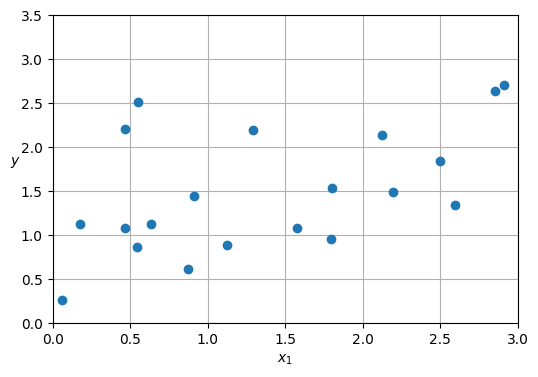

In [31]:
plt.figure(figsize=(6, 4))
plt.plot(X, y, "o")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.grid()
plt.axis([0, 3.0, 0, 3.5])
plt.show()

In [32]:
from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha=0.1, solver='cholesky')
ridge_reg.fit(X,y)
ridge_reg.predict([[1.5]])

array([1.55325833])

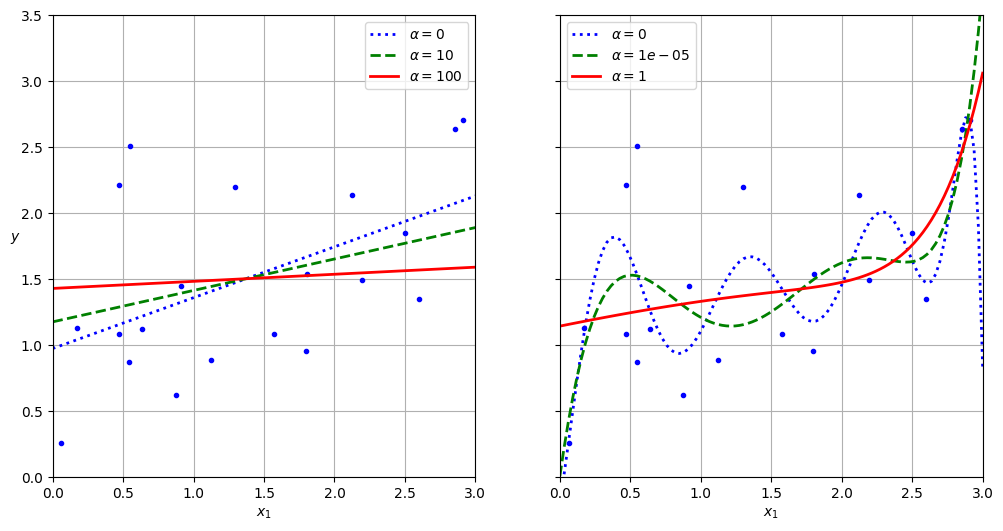

In [59]:
def plot_model(model_class, polynomial, alphas, **model_kwargs):
    plt.plot(X, y, "b.", linewidth=3)
    for alpha, style in zip(alphas, ("b:", "g--", "r-")):
        if alpha > 0:
            model = model_class(alpha, **model_kwargs)
        else:
            model = LinearRegression()
        if polynomial:
            model = Pipeline(
                [
                    (
                        "polynomial_features",
                        PolynomialFeatures(degree=10, include_bias=False),
                    ),
                    ("standard_scaler", StandardScaler()),
                    ("model", model),
                ]
            )
        model.fit(X, y)
        y_new_regular = model.predict(X_new)
        plt.plot(X_new, y_new_regular, style, linewidth=2, label=rf"$\alpha = {alpha}$")
    plt.legend()
    plt.grid()
    plt.xlabel("$x_1$")
    plt.axis([0, 3.0, 0, 3.5])
    

plt.figure(figsize=(12,6))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0,10,100), random_state=42)
plt.ylabel("$y$", rotation=0)

plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)
plt.gca().axes.yaxis.set_ticklabels([])

plt.show()


In [51]:
sgd_reg = SGDRegressor(penalty='l2', alpha=0.1/m, tol=None, max_iter=1000, eta0=0.01, random_state=42)
sgd_reg.fit(X,y.ravel()) # this is for 1D input to fit
sgd_reg.predict([[1.5]])

array([1.55302613])

In [52]:
ridge_reg = Ridge(alpha=0.1, solver='sag', random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([1.55326019])

In [53]:
alpha = 0.1
A = np.array([[0.,0.],[0.,1.]])
X_b = np.c_[np.ones(m), X]
np.linalg.inv(X_b.T @ X_b + alpha * A) @ X_b.T @ y

array([[0.97898394],
       [0.3828496 ]])

In [54]:
ridge_reg.intercept_, ridge_reg.coef_

(array([0.97896386]), array([0.38286422]))

## Lasso Regression

In [ ]:
from sklearn.linear_model import Lasso

lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([1.53788174])

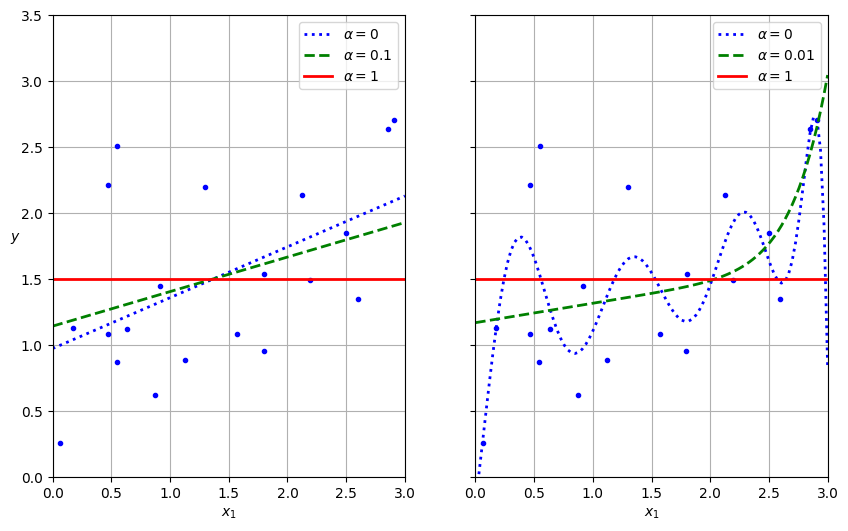

In [58]:
plt.figure(figsize=(10, 6))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$", rotation=0)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 1e-2, 1), random_state=42)
plt.gca().axes.yaxis.set_ticklabels([])
plt.show()